In [5]:
import numpy as np
import plotly.express as ex
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

from tracking.util import to_df, colorscale

Covariace estimated by the Kalman Filter will be lower than either the initial covariance estimate, measurement noise or process noise.

## No process noise

Let's start with initial estimate and measurement noise being equal, no process noise. Repeated Kalman Filter updates are equivalent to an average of N normally-distributed random variables. According to the Central Limit Theorem, variance converges to $\sigma / \sqrt{n}$.

In [48]:
def simulate_variance(P: float, R: float, Q: float):
    trace = [(0, P, 1)]

    for i in range(1, 100):
        K = P / (P + R)
        P = K**2 * R + (1-K)**2 * P + Q
        trace.append((i, P, K))
    
    return np.array(trace)

def simulate_variance_df(P: float, R: float, Q: float):
    return to_df(simulate_variance(P, R, Q), columns=['t', 'P', 'K'])

In [45]:
def plot_variance(**kwargs):
    col = colorscale(x=kwargs.keys())
    fig = make_subplots(rows=1, cols=2, subplot_titles=("P", "K"))
    #fig.update_yaxes(type="log", row=1, col=2)

    for name, data in kwargs.items():
        params = dict(x=data[:,0], mode='lines', marker=dict(color=col[name]))
        fig.add_trace(go.Scatter(y=data[:,1], name=name, **params), row=1, col=1)
        fig.add_trace(go.Scatter(y=data[:,2], name=name, **params, showlegend=False), row=1, col=2)

    return fig

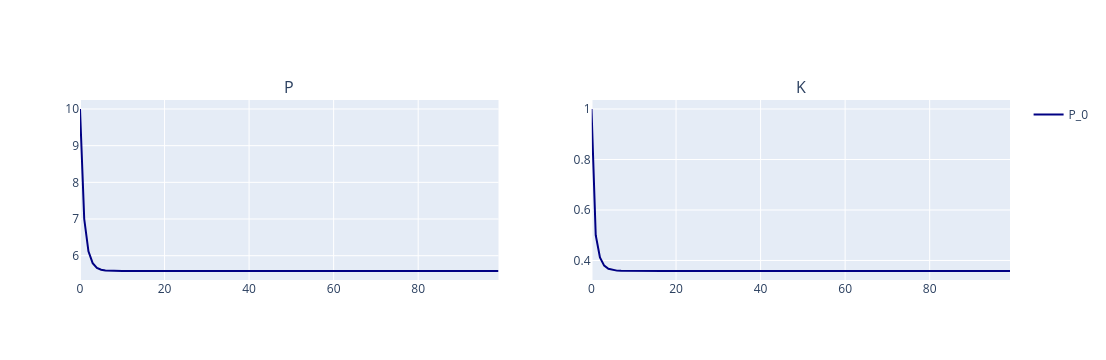

In [46]:
plot_variance(P_0=simulate_variance(10, 10, 2))

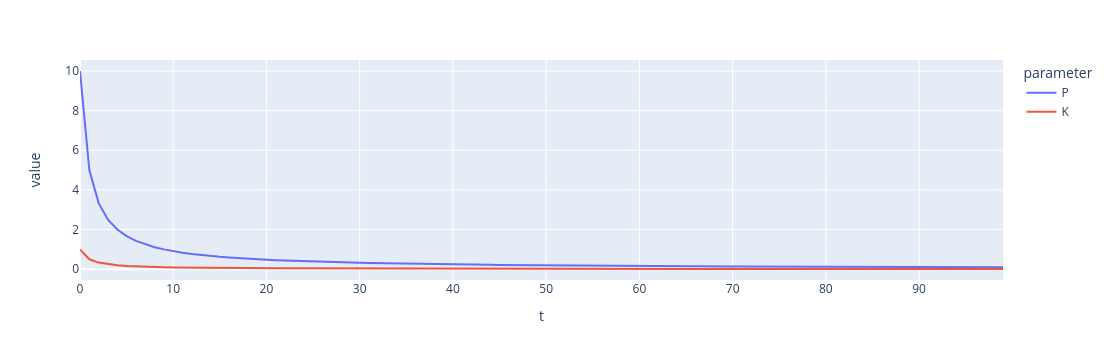

In [51]:
ex.line(simulate_variance_df(10, 10, 0).melt(id_vars=['t'], var_name='parameter'), x='t', y='value', color='parameter')

This is equivalent to the variance an average of N normal random variables with variance $P$. Given the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem):

$$
Var\left(\frac{1}{N}\sum_i^N N(0, \sigma^2)\right) = \frac{\sigma^2}{N}
$$

In [58]:
np.max(simulate_variance(10, 10, 0)[:,1] - 10/np.arange(1, 101))

8.881784197001252e-16

## With process noise

If we introduce process noise, variance converges to a value lower than measurement noise but higher than process noise.

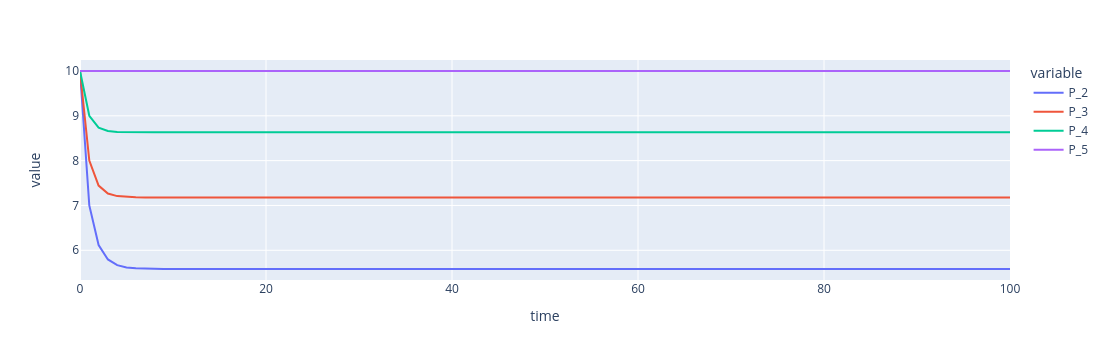

In [20]:
data = pd.DataFrame(dict(P_2=simulate_variance(10, 10, 2),
                         P_3=simulate_variance(10, 10, 3),
                         P_4=simulate_variance(10, 10, 4),
                         P_5=simulate_variance(10, 10, 5),
                         time=range(101)))
data = data.melt(id_vars=['time'])
ex.line(data, x='time', y='value', color='variable')

The limiting variance can be calculate from the following:

$$
K = \frac{P}{P+R}
$$
$$
P = K^2 R + (1-K)^2 P + Q
$$

which can be refomulated as:

$$
P^2 R + R^2 P = (P-Q)(P+R)^2
$$

which for $P=R=10$ and $Q=2$ result in $P=1+\sqrt{21}\approx5.58$ while for $Q=5$ results in $P=10$.

In [59]:
87.2**2

7603.84

In [262]:
H = np.array([[1, 0]])
P = np.eye(2) * 1
R = np.eye(1) * 1
Q = np.eye(2) 
F = np.array([[1, 1], [0, 1]])

In [263]:
for _ in range(100):
    P = F @ P @ F.T + Q
    S = H @ P @ H.T + R
    K = P @ H.T @ np.linalg.inv(S)
    
    P = P - K @ S @ K.T
    
P, K

(array([[0.82184641, 0.42208244],
        [0.42208244, 1.94712297]]),
 array([[0.82184641],
        [0.42208244]]))

In [145]:
class KalmanGain:
    def __init__(self, Px, Pv, Pxv, Qx, Qv, R):
        self.Px = Px
        self.Pv = Pv
        self.Pxv = Pxv
        self.Qx = Qx
        self.Qv = Qv
        self.R = R

    @property
    def S(self):
        return self.Px + 2*self.Pxv + self.Pv + self.Qx + self.R

    @property
    def Kx(self):
        return (self.Px + 2*self.Pxv + self.Pv + self.Qx) / self.S

    @property
    def Kv(self):
        return (self.Pxv + self.Pv) / self.S

In [264]:
kg = KalmanGain(0.81142, 2.1142, 0.18858, 1, 1, 1)
kg.Kx, kg.Kv

(0.811419670437016, 0.4342590113110481)

In [241]:
from sympy.solvers import solve, solveset, nsolve, nonlinsolve
from sympy import Symbol, symbols, N
from sympy.matrices import Matrix

In [251]:
Px, Pv, Pxv = symbols("P_x, P_v, P_xv", positive=True)
Qx, Qv, R, t = 1, 1, 1, 1

F = Matrix([[1, t], [0, 1]])
H = Matrix([[1, 0]])
Q = Matrix([[Qx, 0], [0, Qv]])
Rm = Matrix([R])

P = Matrix([[Px, Pxv], [Pxv, Pv]])
Pn = F*P*F.T + Q
S = H*Pn*H.T + Rm
K = Pn*H.T*S.inv()

X = P - Pn + K*S*K.T

In [252]:
Pn

Matrix([
[P_v + P_x + 2*P_xv + 1, P_v + P_xv],
[            P_v + P_xv,    P_v + 1]])

In [253]:
S

Matrix([[P_v + P_x + 2*P_xv + 2]])

In [254]:
K

Matrix([
[(P_v + P_x + 2*P_xv + 1)/(P_v + P_x + 2*P_xv + 2)],
[            (P_v + P_xv)/(P_v + P_x + 2*P_xv + 2)]])

In [255]:
Pn - K*S*K.T

Matrix([
[P_v + P_x + 2*P_xv - (P_v + P_x + 2*P_xv + 1)**2/(P_v + P_x + 2*P_xv + 2) + 1, P_v + P_xv - (P_v + P_xv)*(P_v + P_x + 2*P_xv + 1)/(P_v + P_x + 2*P_xv + 2)],
[  P_v + P_xv - (P_v + P_xv)*(P_v + P_x + 2*P_xv + 1)/(P_v + P_x + 2*P_xv + 2),                          P_v - (P_v + P_xv)**2/(P_v + P_x + 2*P_xv + 2) + 1]])

In [256]:
X

Matrix([
[-P_v - 2*P_xv + (P_v + P_x + 2*P_xv + 1)**2/(P_v + P_x + 2*P_xv + 2) - 1, -P_v + (P_v + P_xv)*(P_v + P_x + 2*P_xv + 1)/(P_v + P_x + 2*P_xv + 2)],
[   -P_v + (P_v + P_xv)*(P_v + P_x + 2*P_xv + 1)/(P_v + P_x + 2*P_xv + 2),                          (P_v + P_xv)**2/(P_v + P_x + 2*P_xv + 2) - 1]])

In [258]:
res = nonlinsolve([X[0,0], X[0, 1], X[1, 1]], [Px, Pv, Pxv])
res

{(-3/4 + sqrt(21)/4 - sqrt(6 - 2*sqrt(21))/8 + sqrt(126 - 42*sqrt(21))/8, -sqrt(6 - 2*sqrt(21))/2, -sqrt(21)/4 + 1/4 + sqrt(2)*sqrt(3 - sqrt(21))/4), (-3/4 + sqrt(21)/4 - sqrt(126 - 42*sqrt(21))/8 + sqrt(6 - 2*sqrt(21))/8, sqrt(6 - 2*sqrt(21))/2, -sqrt(21)/4 + 1/4 - sqrt(2)*sqrt(3 - sqrt(21))/4), (-sqrt(21)/4 - 3/4 + sqrt(6 + 2*sqrt(21))/8 + sqrt(126 + 42*sqrt(21))/8, sqrt(6 + 2*sqrt(21))/2, -sqrt(2)*sqrt(3 + sqrt(21))/4 + 1/4 + sqrt(21)/4), (-sqrt(126 + 42*sqrt(21))/8 - sqrt(21)/4 - 3/4 - sqrt(6 + 2*sqrt(21))/8, -sqrt(6 + 2*sqrt(21))/2, 1/4 + sqrt(2)*sqrt(3 + sqrt(21))/4 + sqrt(21)/4)}

In [259]:
num = [tuple([x.evalf() for x in solution]) for solution in res]
num

[(0.821846413518260, 1.94712296670701, 0.422082440385453),
 (-4.61313426099618, -1.94712296670701, 2.36920540709247),
 (0.39564392373896 + 0.796714335936263*I,
  -0.889543617524132*I,
  -0.89564392373896 + 0.444771808762066*I),
 (0.39564392373896 - 0.796714335936263*I,
  0.889543617524132*I,
  -0.89564392373896 - 0.444771808762066*I)]

In [261]:
kg = KalmanGain(*num[0], Qx, Qv, R)
kg.Kx, kg.Kv

(0.821846413518260, 0.422082440385453)

In [202]:
?nonlinsolve

Signature: nonlinsolve(system, *symbols)
Docstring:
Solve system of $N$ nonlinear equations with $M$ variables, which means both
under and overdetermined systems are supported. Positive dimensional
system is also supported (A system with infinitely many solutions is said
to be positive-dimensional). In a positive dimensional system the solution will
be dependent on at least one symbol. Returns both real solution
and complex solution (if they exist).

Parameters

system : list of equations
    The target system of equations
symbols : list of Symbols
    symbols should be given as a sequence eg. list

Returns

A :class:`~.FiniteSet` of ordered tuple of values of `symbols` for which the `system`
has solution. Order of values in the tuple is same as symbols present in
the parameter `symbols`.

Please note that general :class:`~.FiniteSet` is unordered, the solution
returned here is not simply a :class:`~.FiniteSet` of solutions, rather it
is a :class:`~.FiniteSet` of ordered tuple, i.e. th